[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pymc-labs/ai_decision_workshop/blob/main/notebooks/02_bayesian_bandits.ipynb)

# Bayesian Bandits

> If running in Google Colab, run this cell to install the `preliz` package.

In [1]:
%pip install preliz

/var/home/fonnesbeck/labs/ai_decision_workshop/.pixi/envs/default/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import preliz as pz

plt.rcParams['figure.dpi'] = 75
plt.rcParams['figure.figsize'] = (6.4, 3.2)

np.random.seed(RANDOM_SEED:=42)

A few utility functions:

In [3]:
def plot_prior(trace, **options):
    return az.plot_posterior(trace, group='prior', **options);

def plot_posterior_predictive(trace, **options):
    return az.plot_posterior(trace, group='posterior_predictive', **options);

## A/B Testing

Let's get back to the first example from the previous notebook, estimating the conversion rate of an email campaign.

For purposes of simulation, let's assume that the actual long run conversion rate for version A is 10%.
We'll use a dictionary to keep track of this probability, `p`, the number of times we have tested this version, `n`, and the number of successful conversions, `k`.

In [4]:
A = dict(p=0.1, n=0, k=0)

When we run a campaign, we'll update this dictionary with the number of people we contact and the number of conversions, drawn from a binomial distribution with parameters `n` and `p`.

In [5]:
from scipy.stats import binom

def run_campaign(d, n=100):
    np.random.seed(RANDOM_SEED)
    d['n'] += n
    d['k'] += binom.rvs(n=n, p=d['p'])

As an example, suppose we send version A to 100 people.

In [6]:
run_campaign(A, 100)
A

{'p': 0.1, 'n': 100, 'k': 9}

We can use the model from the previous notebook to estimate the conversion rate.

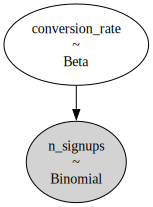

In [7]:
with pm.Model() as model:

    conversion_rate = pm.Beta("conversion_rate", 2, 5)

    pm.Binomial("n_signups", p=conversion_rate, n=A['n'], observed=A['k'])

model.to_graphviz()

In [8]:
with model:
    
    trace = pm.sample(random_seed=RANDOM_SEED)

Initializing NUTS using jitter+adapt_diag...
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{float64}(2)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/var/home/fonnesbeck/labs/ai_decision_workshop/.pixi/envs/default/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/home/fonnesbeck/labs/ai_decision_workshop/.pixi/envs/default/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/var/home/fonnesbeck/labs/ai_decision_workshop/.pixi/envs/default/lib/python3.11/site-packages/pytensor/tensor/rewriting/basic.py", line 1160, in constant_folding
    r

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Here's the posterior distribution.

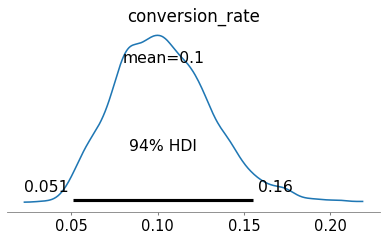

In [9]:
az.plot_posterior(trace);

Now suppose we introduce a new promotion that we think is more enticing, and for the sake of the example, we'll assume it is in fact more effective, so `p=0.15`.

In [10]:
B = dict(p=0.15, n=0, k=0)

But we don't know yet that B is more effective, so we'll do an uneven A/B test where we send the new email to 20 people in the next batch of 100.

In [11]:
run_campaign(A, 80)
A

{'p': 0.1, 'n': 180, 'k': 16}

In [12]:
run_campaign(B, 20)
B

{'p': 0.15, 'n': 20, 'k': 2}

Now let's update our beliefs.

## Loop Back to Here

Here's the previous model extended to estimate conversion rates for A and B.

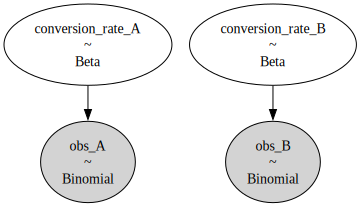

In [13]:
with pm.Model() as model_AB:
    
    # Priors for conversion rates of A and B
    conversion_rate_A = pm.Beta("conversion_rate_A", alpha=2, beta=5)
    conversion_rate_B = pm.Beta("conversion_rate_B", alpha=2, beta=5)
    
    # Likelihoods for observed data
    obs_A = pm.Binomial("obs_A", p=conversion_rate_A, n=A['n'], observed=A['k'])
    obs_B = pm.Binomial("obs_B", p=conversion_rate_B, n=B['n'], observed=B['k'])

model_AB.to_graphviz()

In [14]:
with model_AB:
    trace = pm.sample(random_seed=RANDOM_SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate_A, conversion_rate_B]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Here are the posterior distributions.

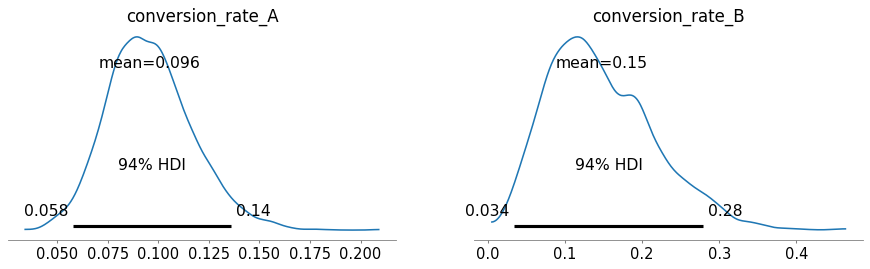

In [15]:
az.plot_posterior(trace);

Here's how we can plot them on the same axes.

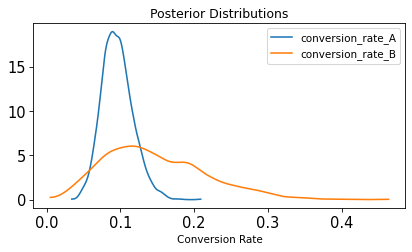

In [16]:
posterior = az.extract(trace)
samples_A = posterior["conversion_rate_A"].values
samples_B = posterior["conversion_rate_B"].values

az.plot_kde(samples_A, label="conversion_rate_A")
az.plot_kde(samples_B, label="conversion_rate_B", plot_kwargs={"color": "C1"})

plt.xlabel("Conversion Rate")
plt.title("Posterior Distributions")
plt.legend();

Based on these results, it looks like B is better, but the distributions overlap, so we might be tempted to run a hypothesis test.

But rather than merely distinguishing between "yes, there's a difference" or "no, there isn't", it is more useful to compute the **distribution** of possible differences. We want to know **how different** the conversion rates are, not just whether they are different.

In [17]:
diff = samples_B - samples_A

Here's what it looks like.

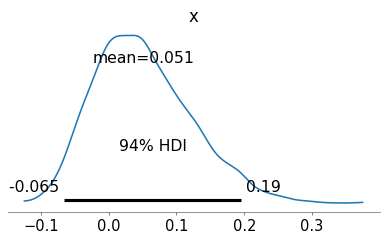

In [18]:
az.plot_posterior(diff, var_names=['x']);

On average, we think B is better (positive difference), but it's still possible that A is better (negative difference).

Here are the probabilities of superiority for A and B.

In [19]:
p_superior_A = (samples_A > samples_B).mean()
p_superior_B = (samples_B > samples_A).mean()

p_superior_A, p_superior_B

(np.float64(0.2585), np.float64(0.7415))

At any point in time, these posterior distributions represent what we *believe* about A and B, but **how do we put those beliefs into action?**

## Thompson Sampling

One option is [Thompson sampling](https://en.wikipedia.org/wiki/Thompson_sampling), where we use A and B in proportion to their probability of superiority.
As long as we are unsure, we use them both about equally.
As we get confident that one is better, we use it more often.

For the next 100 emails, we'll use the probability of superiority to choose the proportions.

In [20]:
n = 100
n_A = (n * p_superior_A).round().astype(int)
n_B = n - n_A

n_A, n_B

(np.int64(26), np.int64(74))

And we'll simulate the campaign.

In [21]:
run_campaign(A, n_A)
A

{'p': 0.1, 'n': np.int64(206), 'k': 18}

In [22]:
run_campaign(B, n_B)
B

{'p': 0.15, 'n': np.int64(94), 'k': 12}

Now go back and run the model again.
If you loop around a few times, you should see:

* The estimated conversion rates for A and B converge to their true values.

* The probability of superiority of B converges to 1.

* We gradually use A less and B more.

This strategy, also known as the [Bayesian bandit strategy](https://en.wikipedia.org/wiki/Multi-armed_bandit), is optimal in the sense that it maximizes expected utility given current beliefs.

## Sequential updating

One of the advertised advantages of Bayesian methods is that they allow us to incorporate prior information into our models. Often this prior information is obtained seqeuntially or incrementally.

If we continue with our example, perhaps we have been given additional budget that allows us to collect additional data for the competing campaigns.

It would make no sense to use a weakly informative prior for the new data. Instead, we should use a prior that is adaptively informed by the previous data. How can we do this?





### Prior elicitation with PreliZ

Our task is to extract information from the posterior distribution of the first experiment to inform the prior distribution for the second experiment.

The key computational task is to determine the appropriate values of the Beta distribution that match our posterior information. We could manually use optimization methods for this, but we will take advantage of the `preliz` package to do this for us. `preliz` is a library aimed at helping practitioners choose prior distributions by implementing functions for facilitating prior elicitation.

Specifically, the `maxent` function finds the **maximum entropy distribution** with mass in the interval defined by the lower and upper end-points.

Let's start by extracting the posterior quantiles from the first experiment.








Posterior quantiles from first experiment:
A: 5% = 0.064, 50% = 0.094, 95% = 0.133
B: 5% = 0.051, 50% = 0.137, 95% = 0.275


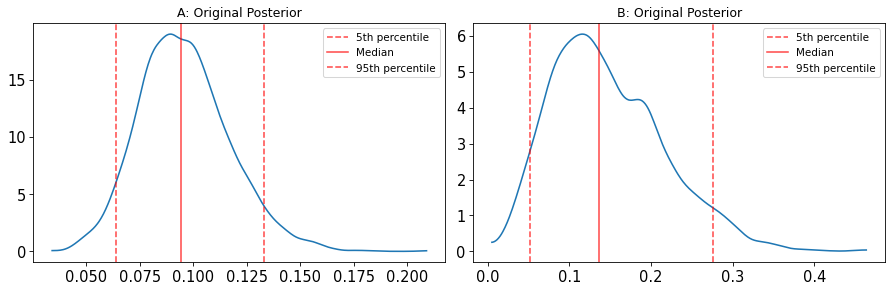

In [23]:
quantiles_A = np.percentile(samples_A, [5, 50, 95])
quantiles_B = np.percentile(samples_B, [5, 50, 95])
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

az.plot_kde(samples_A, ax=axes[0])
axes[0].axvline(quantiles_A[0], color='red', linestyle='--', alpha=0.7, label='5th percentile')
axes[0].axvline(quantiles_A[1], color='red', linestyle='-', alpha=0.7, label='Median')
axes[0].axvline(quantiles_A[2], color='red', linestyle='--', alpha=0.7, label='95th percentile')
axes[0].set_title('A: Original Posterior')
axes[0].legend()

az.plot_kde(samples_B, ax=axes[1])
axes[1].axvline(quantiles_B[0], color='red', linestyle='--', alpha=0.7, label='5th percentile')
axes[1].axvline(quantiles_B[1], color='red', linestyle='-', alpha=0.7, label='Median')
axes[1].axvline(quantiles_B[2], color='red', linestyle='--', alpha=0.7, label='95th percentile')
axes[1].set_title('B: Original Posterior')
axes[1].legend()

plt.tight_layout();

print("Posterior quantiles from first experiment:")
print(f"A: 5% = {quantiles_A[0]:.3f}, 50% = {quantiles_A[1]:.3f}, 95% = {quantiles_A[2]:.3f}")
print(f"B: 5% = {quantiles_B[0]:.3f}, 50% = {quantiles_B[1]:.3f}, 95% = {quantiles_B[2]:.3f}")


Now we'll use `preliz.maxent()` to create Beta distributions that match our posterior information. We'll constrain 90% of the mass to fall between the 5th and 95th percentiles, and fix the median.

Notice that  `preliz` has its own `Beta` class that we can use to parameterize Beta distributions.











In [24]:

# Create informed priors using maxent
prior_A_informed = pz.Beta()
pz.maxent(
    prior_A_informed, 
    lower=quantiles_A[0], 
    upper=quantiles_A[2], 
    mass=0.90,
    fixed_stat=("median", quantiles_A[1]),
    plot=False
)

prior_B_informed = pz.Beta()
pz.maxent(
    prior_B_informed, 
    lower=quantiles_B[0], 
    upper=quantiles_B[2], 
    mass=0.90,
    fixed_stat=("median", quantiles_B[1]),
    plot=False
)

print("Informed priors from maxent:")
print(f"A: {prior_A_informed}")
print(f"B: {prior_B_informed}")

# Compare with original weakly informative priors
print("\nOriginal weakly informative priors:")
print("A: Beta(2, 5)")
print("B: Beta(2, 5)")

Informed priors from maxent:
A: Beta(alpha=19.4, beta=179)
B: Beta(alpha=4.04, beta=22.3)

Original weakly informative priors:
A: Beta(2, 5)
B: Beta(2, 5)


/tmp/ipykernel_534764/3803894721.py:3: UserWarning: 
The requested mass is 0.9,
but the computed one is 0.902
  pz.maxent(
/tmp/ipykernel_534764/3803894721.py:13: UserWarning: 
The requested mass is 0.9,
but the computed one is 0.908
  pz.maxent(


Let's see how these parameterizations compare to the original weakly informative priors, and to the posterior samples from the first experiment.













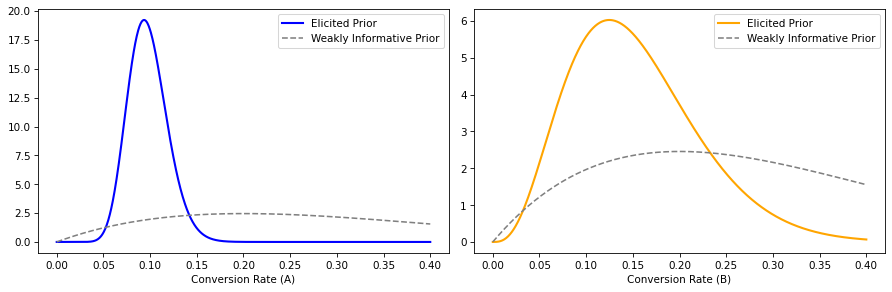

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

x = np.linspace(0, 0.4, 1000)
axes[0].plot(x, prior_A_informed.pdf(x), label='Elicited Prior', color='blue', linewidth=2)
axes[0].plot(x, pz.Beta(2, 5).pdf(x), label='Weakly Informative Prior', color='gray', linestyle='--')
axes[0].legend()
axes[0].set_xlabel('Conversion Rate (A)')

axes[1].plot(x, prior_B_informed.pdf(x), label='Elicited Prior', color='orange', linewidth=2)
axes[1].plot(x, pz.Beta(2, 5).pdf(x), label='Weakly Informative Prior', color='gray', linestyle='--')
axes[1].legend()
axes[1].set_xlabel('Conversion Rate (B)')

plt.tight_layout();

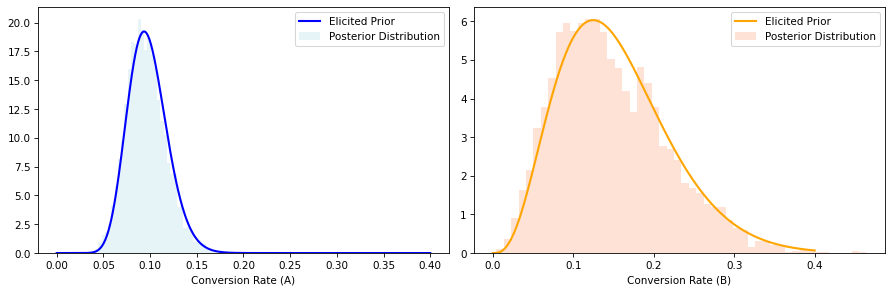

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(x, prior_A_informed.pdf(x), label='Elicited Prior', color='blue', linewidth=2)
axes[0].hist(samples_A, bins=50, density=True, alpha=0.3, color='lightblue', label='Posterior Distribution')
axes[0].legend()
axes[0].set_xlabel('Conversion Rate (A)')

axes[1].plot(x, prior_B_informed.pdf(x), label='Elicited Prior', color='orange', linewidth=2)
axes[1].hist(samples_B, bins=50, density=True, alpha=0.3, color='lightsalmon', label='Posterior Distribution')
axes[1].legend()
axes[1].set_xlabel('Conversion Rate (B)')

plt.tight_layout();

## Second Experiment with New Data

Now let's simulate a second experiment and fit two models: one with naive priors and one with informed priors from our previous experiment.

In [27]:
A_new = dict(p=0.1, n=0, k=0)
B_new = dict(p=0.15, n=0, k=0)

run_campaign(A_new, n=20)
run_campaign(B_new, n=20)

print(f"New experiment results:")
print(f"A: {A_new['k']}/{A_new['n']} = {A_new['k']/A_new['n']:.3f}")
print(f"B: {B_new['k']}/{B_new['n']} = {B_new['k']/B_new['n']:.3f}")

New experiment results:
A: 1/20 = 0.050
B: 2/20 = 0.100


In [28]:
# Model with naive priors (same as original)
with pm.Model() as model_naive:
    conversion_rate_A_naive = pm.Beta("conversion_rate_A", alpha=2, beta=5)
    conversion_rate_B_naive = pm.Beta("conversion_rate_B", alpha=2, beta=5)
    
    obs_A_naive = pm.Binomial("obs_A", p=conversion_rate_A_naive, n=A_new['n'], observed=A_new['k'])
    obs_B_naive = pm.Binomial("obs_B", p=conversion_rate_B_naive, n=B_new['n'], observed=B_new['k'])

# Model with informed priors
with pm.Model() as model_informed:
    conversion_rate_A_informed = pz.maxent(
        pz.Beta(),
        lower=quantiles_A[0], upper=quantiles_A[2],
        mass=0.90,
        fixed_stat=("median", quantiles_A[1]),
        plot=False
    ).to_pymc("conversion_rate_A")
    conversion_rate_B_informed = pz.maxent(
        pz.Beta(),
        lower=quantiles_B[0], upper=quantiles_B[2],
        mass=0.90,
        fixed_stat=("median", quantiles_B[1]),
        plot=False
    ).to_pymc("conversion_rate_B")
    
    obs_A_informed = pm.Binomial("obs_A", p=conversion_rate_A_informed, n=A_new['n'], observed=A_new['k'])
    obs_B_informed = pm.Binomial("obs_B", p=conversion_rate_B_informed, n=B_new['n'], observed=B_new['k'])

print("Models created successfully!")

Models created successfully!


/tmp/ipykernel_534764/2418491090.py:11: UserWarning: 
The requested mass is 0.9,
but the computed one is 0.902
  conversion_rate_A_informed = pz.maxent(
/tmp/ipykernel_534764/2418491090.py:18: UserWarning: 
The requested mass is 0.9,
but the computed one is 0.908
  conversion_rate_B_informed = pz.maxent(


In [29]:
# Sample from both models
with model_naive:
    trace_naive = pm.sample(random_seed=RANDOM_SEED)

with model_informed:
    trace_informed = pm.sample(random_seed=RANDOM_SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate_A, conversion_rate_B]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate_A, conversion_rate_B]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


## Comparing Naive vs Informed Priors

Let's compare how the different priors affect our posterior inference on the new data.

In [30]:
# Extract posterior samples
posterior_naive = az.extract(trace_naive)
posterior_informed = az.extract(trace_informed)

samples_A_naive = posterior_naive["conversion_rate_A"].values
samples_B_naive = posterior_naive["conversion_rate_B"].values
samples_A_informed = posterior_informed["conversion_rate_A"].values  
samples_B_informed = posterior_informed["conversion_rate_B"].values

# Compare posterior summaries
print("Posterior summaries for conversion rate A:")
print(f"Naive prior:    mean = {samples_A_naive.mean():.3f}, std = {samples_A_naive.std():.3f}")
print(f"Informed prior: mean = {samples_A_informed.mean():.3f}, std = {samples_A_informed.std():.3f}")
print(f"True value: {A_new['p']}")

print("\nPosterior summaries for conversion rate B:")
print(f"Naive prior:    mean = {samples_B_naive.mean():.3f}, std = {samples_B_naive.std():.3f}")
print(f"Informed prior: mean = {samples_B_informed.mean():.3f}, std = {samples_B_informed.std():.3f}")
print(f"True value: {B_new['p']}")

Posterior summaries for conversion rate A:
Naive prior:    mean = 0.112, std = 0.059
Informed prior: mean = 0.093, std = 0.020
True value: 0.1

Posterior summaries for conversion rate B:
Naive prior:    mean = 0.147, std = 0.069
Informed prior: mean = 0.130, std = 0.050
True value: 0.15


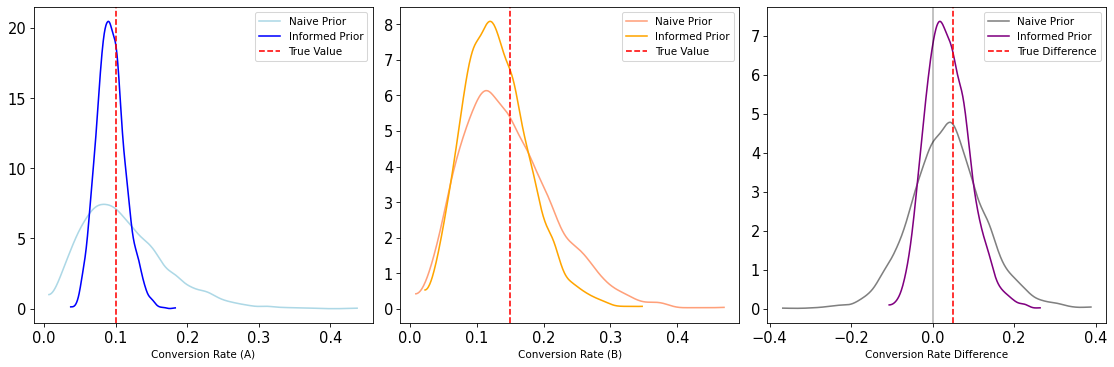

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

az.plot_kde(samples_A_naive, ax=axes[0], plot_kwargs={"label": "Naive Prior", "color": "lightblue"})
az.plot_kde(samples_A_informed, ax=axes[0], plot_kwargs={"label": "Informed Prior", "color": "blue"})
axes[0].axvline(A_new['p'], color='red', linestyle='--', label='True Value')
axes[0].legend()
axes[0].set_xlabel('Conversion Rate (A)')

az.plot_kde(samples_B_naive, ax=axes[1], plot_kwargs={"label": "Naive Prior", "color": "lightsalmon"})
az.plot_kde(samples_B_informed, ax=axes[1], plot_kwargs={"label": "Informed Prior", "color": "orange"})
axes[1].axvline(B_new['p'], color='red', linestyle='--', label='True Value')
axes[1].legend()
axes[1].set_xlabel('Conversion Rate (B)')

diff_naive = samples_B_naive - samples_A_naive
diff_informed = samples_B_informed - samples_A_informed

az.plot_kde(diff_naive, ax=axes[2], plot_kwargs={"label": "Naive Prior", "color": "gray"})
az.plot_kde(diff_informed, ax=axes[2], plot_kwargs={"label": "Informed Prior", "color": "purple"})
axes[2].axvline(B_new['p'] - A_new['p'], color='red', linestyle='--', label='True Difference')
axes[2].axvline(0, color='black', linestyle='-', alpha=0.3)
axes[2].legend()
axes[2].set_xlabel('Conversion Rate Difference')

plt.tight_layout();

In terms of decision-making, we benefit from a model that uses all of the available information. The posterior distributions are much more informative, mainly due to the large sample from conversion rate A in the first experiment. This is reflected in the narrowness of the posterior distributions.

With such a small amount of data, we could easily have just run the second model using the weakly informative priors with all of the data. However in real-world applications, if the quantity of total data is large, it may be more efficient to update the prior incrementally with the new data as it becomes available.